## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Lane Segmentation using Baseline U-Net
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Calculate IoU score
### 3. Lane Segmentation using U-Net with Best practices
> #### 3.0 Define validation and test dataloader
> #### 3.1 Define model architecture
> #### 3.2 Train the model
> #### 3.3 Calculate IoU score
> #### 3.4 Inference on Test dataset

---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Image_Segmentation/camVidzip.zip


Archive:  /content/drive/MyDrive/Image_Segmentation/camVidzip.zip
  inflating: data/CamVid/test/0001TP_008550.png  
  inflating: data/CamVid/test/0001TP_008580.png  
  inflating: data/CamVid/test/0001TP_008610.png  
  inflating: data/CamVid/test/0001TP_008640.png  
  inflating: data/CamVid/test/0001TP_008670.png  
  inflating: data/CamVid/test/0001TP_008700.png  
  inflating: data/CamVid/test/0001TP_008730.png  
  inflating: data/CamVid/test/0001TP_008760.png  
  inflating: data/CamVid/test/0001TP_008790.png  
  inflating: data/CamVid/test/0001TP_008820.png  
  inflating: data/CamVid/test/0001TP_008850.png  
  inflating: data/CamVid/test/0001TP_008880.png  
  inflating: data/CamVid/test/0001TP_008910.png  
  inflating: data/CamVid/test/0001TP_008940.png  
  inflating: data/CamVid/test/0001TP_008970.png  
  inflating: data/CamVid/test/0001TP_009000.png  
  inflating: data/CamVid/test/0001TP_009030.png  
  inflating: data/CamVid/test/0001TP_009060.png  
  inflating: data/CamVid/test/0001

In [3]:
!pip install -U segmentation-models-pytorch
#!pip install git+https://github.com/qubvel/segmentation_models.pytorch -- latest version
#https://github.com/qubvel/segmentation_models.pytorch Makes coding process a lot easier--simply specify name of model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [4]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
import segmentation_models_pytorch.utils
import segmentation_models_pytorch as smp

In [5]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [6]:
x_train_dir = '/content/data/CamVid/train'
y_train_dir = '/content/data/CamVid/trainannot'

x_val_dir = '/content/data/CamVid/val'
y_val_dir = '/content/data/CamVid/valannot'

x_test_dir = '/content/data/CamVid/test'
y_test_dir = '/content/data/CamVid/testannot'

#### 1.2 Define custom dataset and dataloader

In [7]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            ## apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

            return image, mask

        else:
            # read data
            image = Image.open(self.images_paths[i])

            # apply transforms
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

            return image

    def __len__(self):
        return len(self.image_names)

In [8]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### 1.3 Data Exploration

In [9]:
for batch_x, batch_y in train_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [10]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

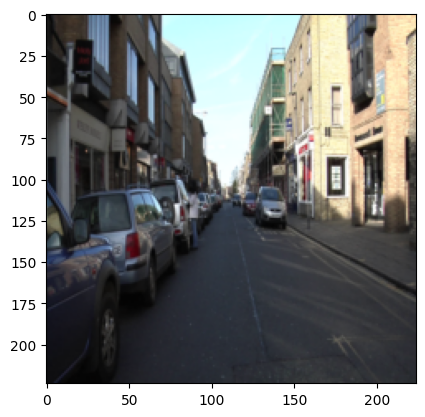

In [11]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

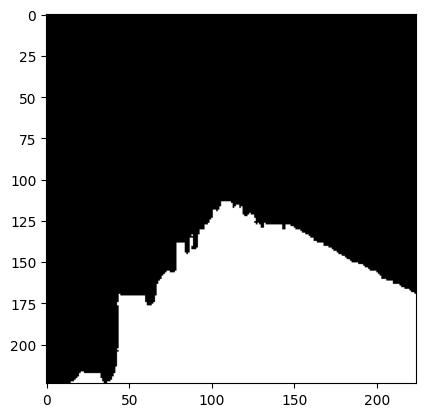

In [12]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [13]:
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

### 2. Lane Segmentation using Baseline U-Net


#### 2.1 Define model architecture

In [14]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


In [15]:
# print model
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [17]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

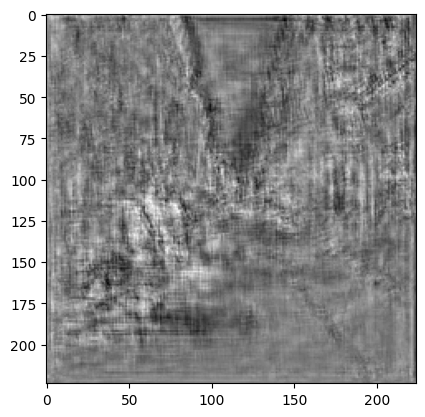

In [18]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 2.2 Train the model

In [19]:
# define loss function
criterion = smp.utils.losses.BCELoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [20]:
# define training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

In [21]:
max_score = 0

for i in range(0, 5):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)


Epoch: 1
train: 100%|██████████| 23/23 [00:05<00:00,  3.87it/s, bce_loss - 0.285, iou_score - 0.7771]

Epoch: 2
train: 100%|██████████| 23/23 [00:05<00:00,  4.27it/s, bce_loss - 0.09592, iou_score - 0.9226]

Epoch: 3
train: 100%|██████████| 23/23 [00:04<00:00,  4.79it/s, bce_loss - 0.07271, iou_score - 0.9304]

Epoch: 4
train: 100%|██████████| 23/23 [00:04<00:00,  5.21it/s, bce_loss - 0.05557, iou_score - 0.9447]

Epoch: 5
train: 100%|██████████| 23/23 [00:06<00:00,  3.62it/s, bce_loss - 0.04648, iou_score - 0.9513]


#### 2.3 Calculate IoU score

In [22]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

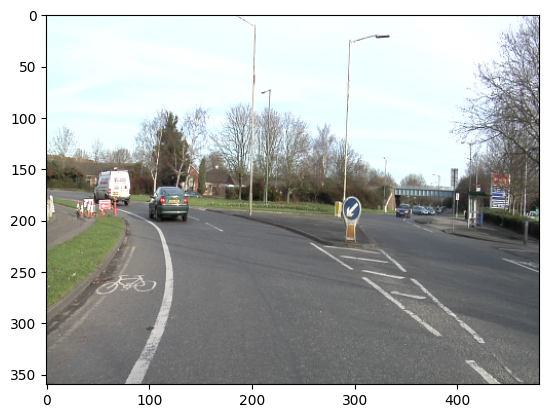

In [23]:
plt.imshow(image)

In [24]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [25]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

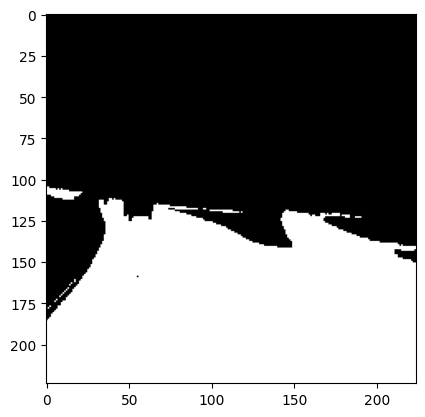

In [26]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

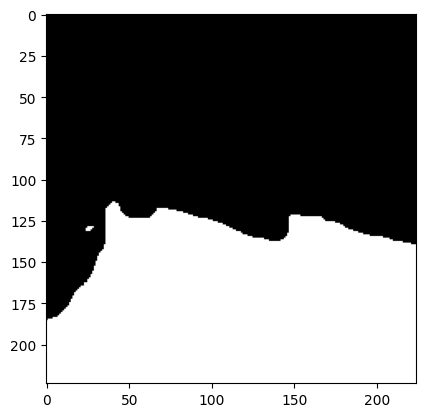

In [27]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [28]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9555857253685027

### 3. Lane Segmentation using U-Net with Best Practices

#### 3.0 Define validation and test dataloaders

In [29]:
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

val_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
val_dataset = CamVidDataset(
    x_val_dir,
    y_val_dir,
    transforms=val_transforms,
    preprocessing=True,
    training_type='val'
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4
)

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
test_dataset = CamVidDataset(
    x_test_dir,
    transforms=test_transforms,
    preprocessing=True,
    training_type='test'
)

#### 3.1 Define model architecture

In [31]:
# Add the following line to the top of the file:
import ssl

# Then, wrap the `urlopen` call in a try-except block:
try:
    ssl._create_default_https_context = ssl._create_unverified_context
    model = smp.Unet(
        encoder_name='densenet121',
        encoder_weights='imagenet',
        classes=1,
        activation='sigmoid',
    )
except URLError as e:
    if isinstance(e.reason, ssl.SSLCertVerificationError):
        print("Error: Certificate has expired. Please renew your certificate or add it to the list of trusted certificates.")
    else:
        raise e

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth
100%|██████████| 30.9M/30.9M [01:30<00:00, 356kB/s]


In [32]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [33]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

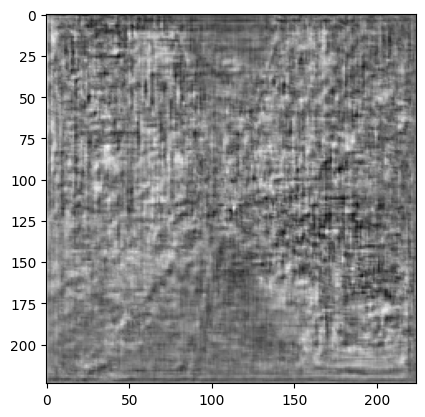

In [34]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

#### 3.2 Train the model

In [35]:
# define loss function
criterion = smp.utils.losses.DiceLoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [36]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    device='cuda',
    verbose=True,
)

In [37]:
# saving best model
max_score = 0

for i in range(0, 15):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)

    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    # decreasing lr to fine tune model
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')


Epoch: 1
valid: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s, dice_loss - 0.2654, iou_score - 0.84]
Model saved!

Epoch: 2
valid: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s, dice_loss - 0.105, iou_score - 0.9271]
Model saved!

Epoch: 3
valid: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s, dice_loss - 0.09448, iou_score - 0.8794]

Epoch: 4
valid: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s, dice_loss - 0.04521, iou_score - 0.9491]
Model saved!

Epoch: 5
valid: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, dice_loss - 0.04325, iou_score - 0.9371]

Epoch: 6
valid: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s, dice_loss - 0.06941, iou_score - 0.884]

Epoch: 7
valid: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s, dice_loss - 0.04861, iou_score - 0.9191]

Epoch: 8
valid: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s, dice_loss - 0.03615, iou_score - 0.9403]

Epoch: 9
valid: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s, dice_loss - 0.02757, iou_score - 0.9544]
Model saved!

Epoch: 10
valid: 

In [38]:
# load best saved checkpoint
model = torch.load('./best_model.pth')

#### 2.3 Calculate IoU score

In [39]:
# get sample data
image = Image.open('/content/data/CamVid/train/0006R0_f00930.png')
gt_mask = Image.open('/content/data/CamVid/trainannot/0006R0_f00930.png')

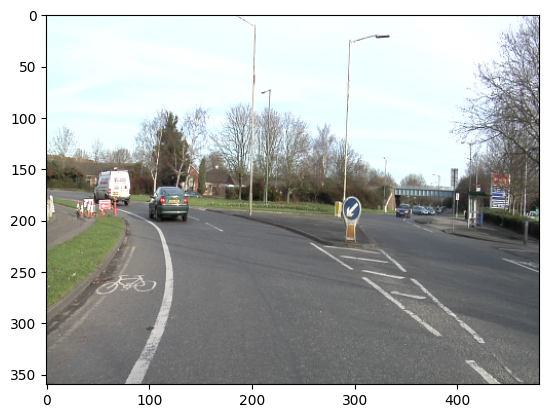

In [40]:
plt.imshow(image)

In [41]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [42]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

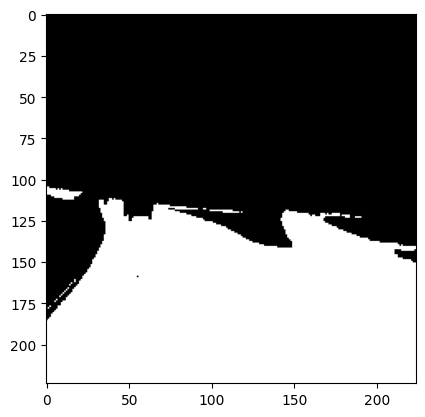

In [43]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

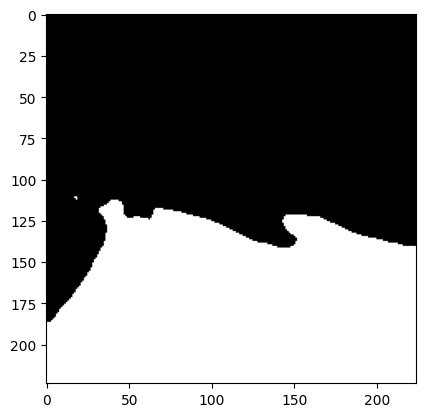

In [44]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [45]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9703852366733565

#### 3.4 Inference on test dataset

In [46]:
# run model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

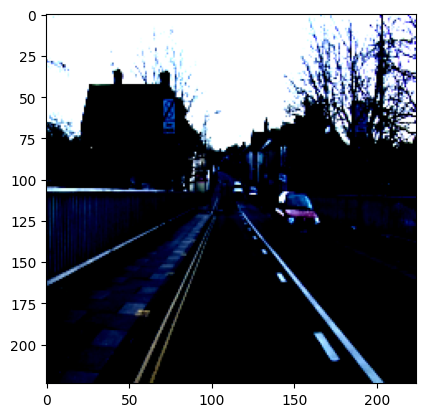

In [47]:
# show original image
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

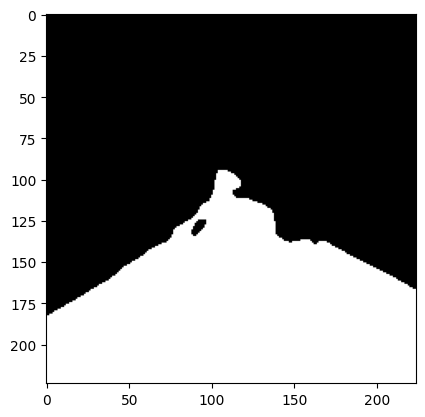

In [48]:
# show prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')